## Cắt tỉa Outlier 


Outlier là một điểm dữ liệu khác biệt rất lớn so với dữ liệu còn lại. “Outlier là một quan sát sai lệch rất nhiều so với các quan sát khác để làm dấy lên nghi ngờ rằng nó được tạo ra bởi một cơ chế khác”. [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Các yếu tố thống kê như giá trị trung bình và phương sai rất dễ bị ảnh hưởng bởi outlier. Ngoài ra, **một số mô hình học máy nhạy với các outlier** có thể làm giảm chất lượng của chúng. Do đó, chúng ta thường loại bỏ outlier khỏi các biến tùy thuộc vào thuật toán mà chúng ta muốn huấn luyện.

Chúng ta đã thảo luận cách xác định outlier và trong phần này, chúng ta sẽ bàn về cách xử lý chúng để huấn luyện các mô hình học máy.


## Làm thế nào để tiền xử lý outlier?

- Trimming (Cắt tỉa): loại bỏ các outlier khỏi tập dữ liệu.
- Coi các outlier là dữ liệu bị khuyết và tiến hành với bất kỳ kỹ thuật gán dữ liệu bị khuyết nào.
- Rời rạc hóa: outlier được thay thế trong các border bin cùng với các giá trị cao hoặc thấp hơn của phân phối. 
- Censoring (Kiểm duyệt): giới hạn phân phối biến ở giá trị max/min.

**Censoring** cũng được biết đến như:

- top/bottom coding
- winsorization
- capping


## Trimming?Truncation

Trimming/Truncation liên quan đến việc loại bỏ các outlier khỏi tập dữ liệu. Chúng ta chỉ cần quyết định một phép đo để xác định outlier. Đó có thể là phép xấp xỉ Gauss cho các biến được phân phối chuẩn hoặc quy tắc tiệm cận IQR cho các biến lệch.

### Ưu điểm

- nhanh

### Hạn chế

- Các outlier cho một biến có thể chứa thông tin hữu ích trong các biến khác.
- Chúng ta có thể loại phần lớn tập dữ liệu nếu có outlier trong nhiều biến.

## Trong bản mô phỏng này

Chúng ta sẽ thực hiện cắt tỉa sử dụng tập dữ liệu Boston House.

## Quan trọng

Outlier cần được phát hiện VÀ **CHỈ loại bỏ** khỏi tập huấn luyện chứ KHÔNG loại bỏ khỏi tập kiểm tra.

Trước tiên, chúng ta nên chia dữ liệu thành tập huấn luyện và tập kiểm tra, rồi loại bỏ outlier trong tập huấn luyện nhưng giữ outlier lại trong tập kiểm tra và đo chất lượng của mô hình.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# cho biểu đồ Q-Q
import scipy.stats as stats

# tập dữ liệu boston house cho mô phỏng
from sklearn.datasets import load_boston

In [2]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [3]:
# hàm tạo biểu đồ tần suất, biểu đồ Q-Q và
# biểu đồ hộp đã học trước đó


def diagnostic_plots(df, variable):
    # hàm nhận dataframe (df) và
    # biến cần quan tâm làm đối số

    # xác định kích thước figure
    plt.figure(figsize=(16, 4))

    # biểu đồ tần suất
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # biểu đồ Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # biểu đồ hộp
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

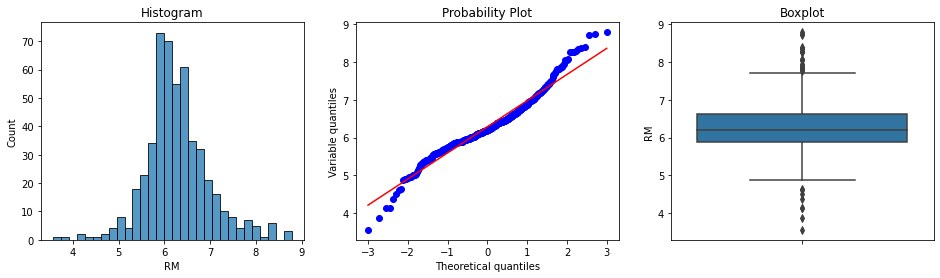

In [4]:
# tìm các outlier trong RM

diagnostic_plots(boston, 'RM')

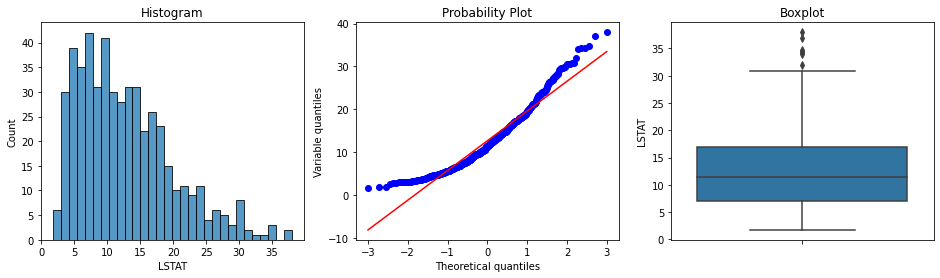

In [5]:
# hiển thị các outlier trong LSTAT

diagnostic_plots(boston, 'LSTAT')

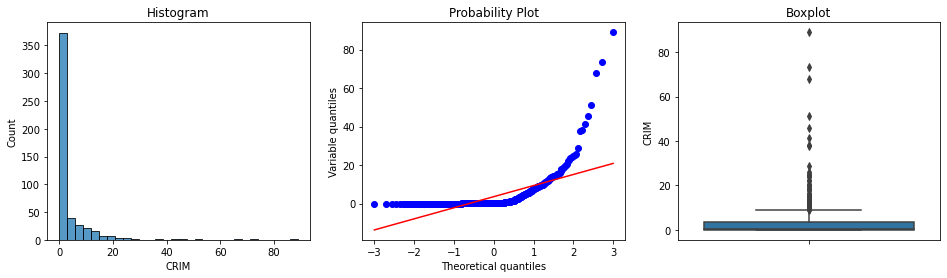

In [6]:
# các outlier trong CRIM

diagnostic_plots(boston, 'CRIM')

Tất cả các biến trên đều có outlier. RM hiển thị các outlier ở cả hai đầu, trong khi LSTAT và CRIM chỉ có ở phần đuôi bên phải.

Để tìm outlier, hãy sử dụng lại hàm chúng ta đã học:

In [7]:
## Yêu cầu 1
def find_skewed_boundaries(df, variable, distance):

    # tính các ranh giới bên ngoài có outlier
    # cho các phân phối lệch

    # truyền distance làm đối số, cho chúng ta lựa chọn
    # ước tính 1.5 * IQR hoặc 3 * IQR để tính
    # các ranh giới.

    ## VIẾT CODE Ở ĐÂY:
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    ## VIẾT CODE Ở ĐÂY:
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    ## VIẾT CODE Ở ĐÂY:
    return upper_boundary, lower_boundary

In [8]:
## Yêu cầu 2
# tìm các giới hạn cho RM

## VIẾT CODE Ở ĐÂY:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [10]:
## Yêu cầu 3
# các giới hạn cho LSTAT

## VIẾT CODE Ở ĐÂY:
LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston,'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [11]:
## Yêu cầu 4
# các giới hạn cho CRIM

## VIẾT CODE Ở ĐÂY:
CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston,'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

In [12]:
## Yêu cầu 5: gắn cờ các outlier trong tập dữ liệu

## VIẾT CODE Ở ĐÂY:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [14]:
## Yêu cầu 6: gắn cờ các outlier trong tập dữ liệu

## VIẾT CODE Ở ĐÂY:
outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [15]:
## Yêu cầu 7: gắn cờ các outlier trong tập dữ liệu

## VIẾT CODE Ở ĐÂY:
outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [17]:
## Yêu cầu 8: cắt tỉa tập dữ liệu

## VIẾT CODE Ở ĐÂY:
boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]

## VIẾT CODE Ở ĐÂY:
boston.shape, boston_trimmed.shape

((506, 3), (416, 3))

Bằng cách cắt tỉa, chúng ta đã loại bỏ gần 100 hàng từ tập dữ liệu gồm 500 hàng, tức là có khoảng 20% dữ liệu đã bị loại bỏ. Đây là lý do chính mà chúng ta thường không sử dụng cắt tỉa nhiều trong học máy. Nhưng nếu chỉ một vài biến biểu diễn tỷ lệ outlier nhỏ thì có thể cắt tỉa.

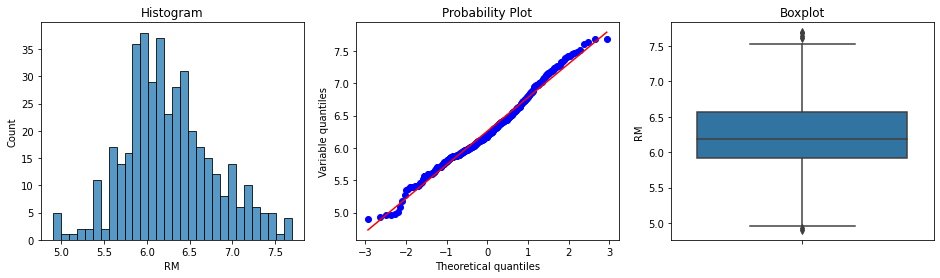

In [18]:
# khám phá các outlier trong tập dữ liệu đã cắt tỉa
# với RM, chúng ta thấy có ít outlier hơn so với tập dữ liệu gốc

diagnostic_plots(boston_trimmed, 'RM')

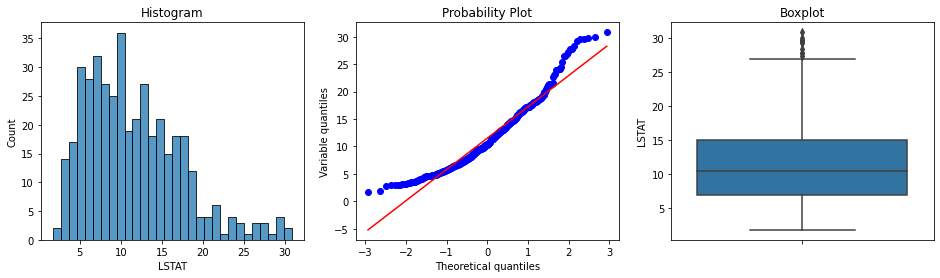

In [19]:
diagnostic_plots(boston_trimmed, 'LSTAT')

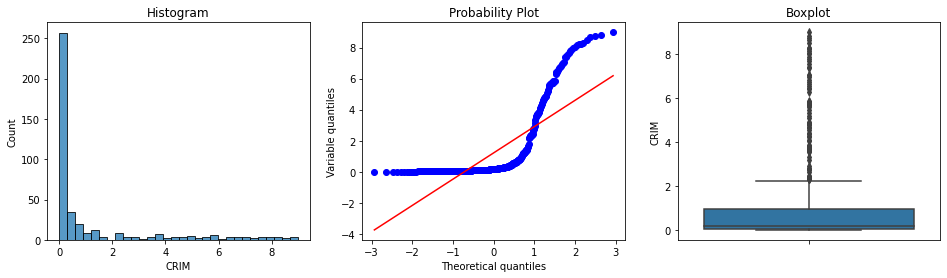

In [20]:
diagnostic_plots(boston_trimmed, 'CRIM')

Với LSTAT và CRIM, chúng ta vẫn thấy nhiều outlier. Khi chúng ta xóa các điểm dữ liệu khỏi tập dữ liệu, tất cả các tham số của phân phối (mean, quantile và IQR) sẽ được tính toán lại, do đó, các giá trị trước đây không được coi là outlier bây giờ lại là outlier trong biến -trimmed- mới.

Đây là một đặc điểm không mong muốn của cách xử lý outlier này. 

## Mới: outlier trimming với Feature-engine

Tìm hiểu thêm về cắt tỉa outlier với Feature-engine trong tài liệu:

https://feature-engine.readthedocs.io/en/latest/outliers/OutlierTrimmer.html